# Setup Lingkungan
Sebelum memulai, pastikan Anda menjalankan notebook ini di Google Colab atau lingkungan lokal dengan file data berikut sudah diunggah:

* data2.json: Data percakapan chatbot.
* stopword_list_tala.txt: Daftar kata stopword khusus.
* id.vec: Embedding FastText untuk Bahasa Indonesia.

Instal paket Python yang diperlukan dengan menjalankan perintah berikut:

In [6]:
!pip install tensorflow==2.15.0 gensim keras-tuner imbalanced-learn Sastrawi sentencepiece seqeval tensorflow-addons

# Mengimpor Library
Kita akan mengimpor semua library yang diperlukan untuk memproses data, membangun model, dan melakukan evaluasi.

In [7]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Dense, Input, Dropout, Bidirectional, LSTM, Embedding, Layer)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report as sk_classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import re
import pickle
import os
import io
import random
import nltk
import gensim
from gensim.models import KeyedVectors
from tensorflow.keras.callbacks import EarlyStopping
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from seqeval.metrics import classification_report as seqeval_classification_report
import tensorflow_addons as tfa
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Memuat dan Memproses Data
**1. Memuat Embedding FastText**

FastText adalah model embedding kata yang dapat membantu chatbot memahami konteks kata dalam Bahasa Indonesia.

In [8]:
# # Download FastText
# !wget -O id.tar.gz "https://www.dropbox.com/scl/fi/sju4o3keikox69euw51vy/id.tar.gz?rlkey=5jr3ijtbdwfahq7xcgig28qvy&e=1&st=gntzkzeo&dl=1"
# !tar -xzf id.tar.gz

In [9]:
# Memuat FastText
try:
    fasttext_model = KeyedVectors.load_word2vec_format('id.vec', binary=False)
    print("FastText 'id.vec' berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat 'id.vec': {e}")
    raise ValueError("Gagal memuat FastText.")

FastText 'id.vec' berhasil dimuat.


**2. Memuat Data Percakapan dan Stopwords**

Kita akan memuat data percakapan dari file JSON dan daftar stopwords khusus.

In [10]:
# Memuat data percakapan
with open('data2.json', 'r', encoding='utf-8') as f:
    conversations = json.load(f)

# Memuat stopwords khusus
with open('stopword_list_tala.txt', 'r', encoding='utf-8') as f:
    stop_words = f.read().splitlines()
stop_words = set(word.strip().lower() for word in stop_words)

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

**3. Fungsi Pembersihan dan Preprocessing Teks**

Fungsi ini akan membersihkan teks, menghapus stopwords, dan melakukan stemming untuk mempermudah pemrosesan selanjutnya.

In [11]:
def clean_text(text):
    """
    Mengubah teks menjadi huruf kecil dan menghapus karakter non-alfanumerik.
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def preprocess_text(text):
    """
    Membersihkan teks, menghapus stopwords, dan melakukan stemming.
    """
    text = clean_text(text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    return ' '.join(tokens)

**4. Mengubah Offset Karakter menjadi Label Token untuk NER**

Data entitas biasanya diberikan dalam bentuk offset karakter. Kita perlu mengubahnya menjadi label per token untuk digunakan dalam model NER.

In [12]:
def char_offset_to_token_labels(utterance, entities, tokenizer=lambda x: x.split()):
    """
    Mengubah offset karakter menjadi label token untuk NER.
    """
    tokens = tokenizer(utterance)
    labels = ["O"] * len(tokens)
    char_pos = 0
    token_ranges = []
    for t in tokens:
        start_pos = char_pos
        end_pos = start_pos + len(t)
        token_ranges.append((start_pos, end_pos))
        char_pos = end_pos + 1
    for ent in entities:
        ent_start = ent['start']
        ent_end = ent['end']
        ent_type = ent['entity'].upper()
        ent_token_positions = []
        for i, (ts, te) in enumerate(token_ranges):
            if not (te <= ent_start or ts >= ent_end):
                ent_token_positions.append(i)
        if len(ent_token_positions) > 0:
            labels[ent_token_positions[0]] = "B-" + ent_type
            for p in ent_token_positions[1:]:
                labels[p] = "I-" + ent_type
    return tokens, labels

**5. Ekstraksi Utterance Pengguna, Intent, dan Entitas**

Kita akan mengurai data percakapan untuk mendapatkan utterance dari pengguna, intent, dan entitas yang terdeteksi.

In [13]:
user_utterances = []
intents = []
entity_labels = []

for conv in conversations:
    for turn in conv["turns"]:
        if turn["speaker"] == "user":
            utt = turn["utterance"]
            ents = turn.get("entities", [])
            intent = turn.get("intent", "None")
            tokens, ner_tags = char_offset_to_token_labels(utt, ents)
            user_utterances.append(tokens)
            intents.append(intent)
            entity_labels.append(ner_tags)

# Menggabungkan token kembali menjadi string
utterances_joined = [' '.join(utt) for utt in user_utterances]
utterances_clean = [preprocess_text(u) for u in utterances_joined]

# Membuat DataFrame
df_data = pd.DataFrame({
    'utterances': utterances_joined,
    'intent': intents,
    'entities': entity_labels,
    'utterances_clean': utterances_clean
})

**6. Mengkodekan Label Intent**

Mengubah label intent tekstual menjadi label numerik agar bisa digunakan dalam model machine learning.

In [14]:
label_encoder = LabelEncoder()
df_data['intent_label'] = label_encoder.fit_transform(df_data['intent'])

**7. Menangani Ketidakseimbangan Kelas dengan Random OverSampling**

Agar model tidak bias terhadap kelas yang lebih dominan, kita akan menyeimbangkan dataset menggunakan teknik oversampling.

In [15]:
ros = RandomOverSampler(random_state=42)
X = df_data.index.values.reshape(-1, 1)
y = df_data['intent_label']
X_ros, y_ros = ros.fit_resample(X, y)
df_balanced = df_data.loc[X_ros.flatten()].reset_index(drop=True)
df_balanced['intent_label'] = y_ros
df_balanced['intent'] = label_encoder.inverse_transform(df_balanced['intent_label'])

**8. Menyiapkan Data untuk Pelatihan dan Validasi**

Membagi data menjadi set pelatihan dan validasi untuk mengevaluasi performa model.

In [16]:
texts = df_balanced['utterances_clean'].tolist()
labels = df_balanced['intent_label'].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

**9. Tokenisasi Data Teks**

Mengubah teks menjadi urutan angka menggunakan tokenizer.

In [17]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='')
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
max_seq_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in val_sequences))
print("max_seq_length:", max_seq_length)

train_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_seq_length, padding='post')

max_seq_length: 9


**10. One-Hot Encode Label**

Mengubah label menjadi format kategorikal agar bisa digunakan dalam pelatihan model.

In [18]:
num_classes = len(label_encoder.classes_)
train_labels_cat = to_categorical(train_labels, num_classes=num_classes)
val_labels_cat = to_categorical(val_labels, num_classes=num_classes)

**11. Membuat Matriks Embedding**

Membuat matriks embedding menggunakan embedding FastText. Jika kata tidak ada dalam FastText, kita mengisinya dengan vektor acak.

In [19]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_index.items():
    if word in fasttext_model:
        embedding_matrix[idx] = fasttext_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

**12. Menyiapkan Label NER**

Mengubah label entitas menjadi format yang bisa diproses oleh model NER.

In [20]:
# Mengumpulkan semua label NER unik
all_labels = set()
for tags in df_balanced['entities']:
    for t in tags:
        if t != 'O':
            all_labels.add(t)
all_labels.add('O')
all_labels = sorted(list(all_labels))

ner_label_encoder = {label: idx for idx, label in enumerate(all_labels)}
ner_label_decoder = {idx: label for label, idx in ner_label_encoder.items()}

def encode_tags(tags, max_len):
    tag_ids = [ner_label_encoder[t] for t in tags]
    tag_ids = tag_ids[:max_len] + [ner_label_encoder['O']]*(max_len - len(tag_ids))
    return tag_ids

def text_to_sequence(text):
    seq = tokenizer.texts_to_sequences([text])
    return seq[0]

# Menyiapkan data NER
X_ner = []
Y_ner = []
for i, row in df_balanced.iterrows():
    seq = text_to_sequence(row['utterances_clean'])
    seq_padded = seq[:max_seq_length] + [0]*(max_seq_length - len(seq))
    X_ner.append(seq_padded)
    tag_ids = encode_tags(row['entities'], max_seq_length)
    Y_ner.append(tag_ids)

X_ner = np.array(X_ner)
Y_ner = np.array(Y_ner)
Y_ner = to_categorical(Y_ner, num_classes=len(ner_label_encoder))

# Membagi data menjadi set pelatihan dan validasi
train_texts_ner, val_texts_ner, train_labels_ner, val_labels_ner = train_test_split(
    X_ner,
    Y_ner,
    test_size=0.2,
    random_state=42
)

# Membangun Model Klasifikasi Intent
**1. Mendefinisikan Layer Attention**

Layer attention membantu model fokus pada bagian penting dari input saat memproses data.

In [21]:
@tf.keras.utils.register_keras_serializable(package='Custom')
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(1,),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.squeeze(tf.tensordot(x, self.W, axes=1), axis=-1) + self.b
        alpha = tf.nn.softmax(e)
        alpha = tf.expand_dims(alpha, axis=-1)
        context = x * alpha
        return tf.reduce_sum(context, axis=1)

**2. Membangun Model Klasifikasi Intent**

Menggunakan layer embedding, LSTM bidirectional, attention, dan dense layer untuk membangun model klasifikasi intent.

In [22]:
def build_intent_model(embedding_matrix, max_seq_length, num_classes, l2_reg=1e-3):
    inputs = Input(shape=(max_seq_length,), dtype='int32')
    emb = Embedding(input_dim=embedding_matrix.shape[0],
                    output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],
                    input_length=max_seq_length,
                    trainable=True, mask_zero=True)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(emb)
    att = AttentionLayer()(x)
    dense = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(att)
    dropout = Dropout(0.5)(dense)
    outputs = Dense(num_classes, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

**3. Melatih Model Klasifikasi Intent**

Melatih model dengan data pelatihan dan memantau performa pada data validasi menggunakan early stopping.

In [23]:
model_intent = build_intent_model(embedding_matrix, max_seq_length, num_classes)
early_intent = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_intent = model_intent.fit(
    train_padded, train_labels_cat,
    validation_data=(val_padded, val_labels_cat),
    epochs=30, batch_size=16,
    callbacks=[early_intent]
)

Epoch 1/30
18/18 [==============================] - 29s 382ms/step - loss: 1.6243 - accuracy: 0.4357 - val_loss: 1.3007 - val_accuracy: 0.4571
Epoch 2/30
18/18 [==============================] - 5s 262ms/step - loss: 1.0653 - accuracy: 0.6714 - val_loss: 0.7384 - val_accuracy: 0.8286
Epoch 3/30
18/18 [==============================] - 3s 141ms/step - loss: 0.6087 - accuracy: 0.8679 - val_loss: 0.4841 - val_accuracy: 0.9000
Epoch 4/30
18/18 [==============================] - 2s 98ms/step - loss: 0.3811 - accuracy: 0.9179 - val_loss: 0.3739 - val_accuracy: 0.9000
Epoch 5/30
18/18 [==============================] - 2s 138ms/step - loss: 0.2607 - accuracy: 0.9714 - val_loss: 0.2831 - val_accuracy: 0.9429
Epoch 6/30
18/18 [==============================] - 2s 95ms/step - loss: 0.2200 - accuracy: 0.9893 - val_loss: 0.3532 - val_accuracy: 0.9286
Epoch 7/30
18/18 [==============================] - 1s 74ms/step - loss: 0.1691 - accuracy: 0.9893 - val_loss: 0.2844 - val_accuracy: 0.9429
Epoch 8/

# Membangun Model NER dengan CRF
**1. Mendefinisikan Loss dan Metrics CRF**

CRF (Conditional Random Fields) membantu model NER dalam menangkap dependensi antar label.

In [24]:
num_entities = len(ner_label_encoder)
transition_params = tf.Variable(tf.random.uniform(shape=(num_entities, num_entities)))

def build_ner_crf_model(embedding_matrix, max_seq_length, num_entities):
    inputs = Input(shape=(max_seq_length,))
    emb = Embedding(input_dim=embedding_matrix.shape[0],
                    output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],
                    trainable=True, mask_zero=False)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(emb)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    logits = Dense(num_entities)(x)
    model = Model(inputs, logits)
    return model

def crf_loss(y_true, y_pred):
    y_true_idx = tf.argmax(y_true, axis=-1)
    log_likelihood, _ = tfa.text.crf_log_likelihood(y_pred, y_true_idx,
                                                    tf.fill([tf.shape(y_pred)[0]], max_seq_length),
                                                    transition_params)
    return -tf.reduce_mean(log_likelihood)

def crf_viterbi_accuracy(y_true, y_pred):
    y_true_idx = tf.argmax(y_true, axis=-1, output_type=tf.int32)
    viterbi_seq, _ = tfa.text.crf_decode(y_pred, transition_params, tf.fill([tf.shape(y_pred)[0]], max_seq_length))
    match = tf.cast(tf.equal(y_true_idx, viterbi_seq), tf.float32)
    return tf.reduce_mean(match)

**2. Membangun dan Mengompilasi Model NER**

In [25]:
model_ner_crf = build_ner_crf_model(embedding_matrix, max_seq_length, num_entities)
model_ner_crf.compile(optimizer='adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])

**3. Melatih Model NER**

Melatih model NER dengan data pelatihan dan memantau performa pada data validasi menggunakan early stopping.

In [26]:
early_ner = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_ner = model_ner_crf.fit(
    train_texts_ner, train_labels_ner,
    validation_data=(val_texts_ner, val_labels_ner),
    epochs=30, batch_size=16,
    callbacks=[early_ner]
)

Epoch 1/30
18/18 [==============================] - 23s 222ms/step - loss: 12.4290 - crf_viterbi_accuracy: 0.6447 - val_loss: 6.9357 - val_crf_viterbi_accuracy: 0.7523
Epoch 2/30
18/18 [==============================] - 2s 132ms/step - loss: 6.2980 - crf_viterbi_accuracy: 0.7581 - val_loss: 6.3512 - val_crf_viterbi_accuracy: 0.7824
Epoch 3/30
18/18 [==============================] - 2s 126ms/step - loss: 5.3548 - crf_viterbi_accuracy: 0.7720 - val_loss: 5.5038 - val_crf_viterbi_accuracy: 0.7875
Epoch 4/30
18/18 [==============================] - 3s 191ms/step - loss: 4.7236 - crf_viterbi_accuracy: 0.7944 - val_loss: 5.1159 - val_crf_viterbi_accuracy: 0.7949
Epoch 5/30
18/18 [==============================] - 4s 201ms/step - loss: 4.2735 - crf_viterbi_accuracy: 0.8121 - val_loss: 4.8458 - val_crf_viterbi_accuracy: 0.8343
Epoch 6/30
18/18 [==============================] - 2s 128ms/step - loss: 3.9077 - crf_viterbi_accuracy: 0.8391 - val_loss: 4.6188 - val_crf_viterbi_accuracy: 0.8481
Ep

# Evaluasi Model
**1. Plot Riwayat Pelatihan**

Visualisasikan perkembangan loss dan akurasi selama pelatihan untuk kedua model.

In [36]:
os.makedirs('models', exist_ok=True)

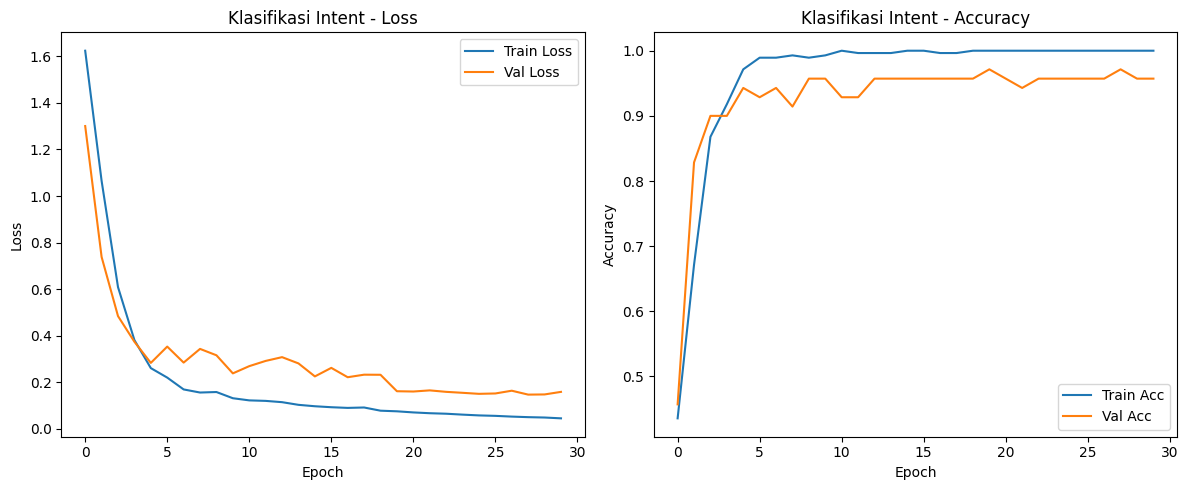

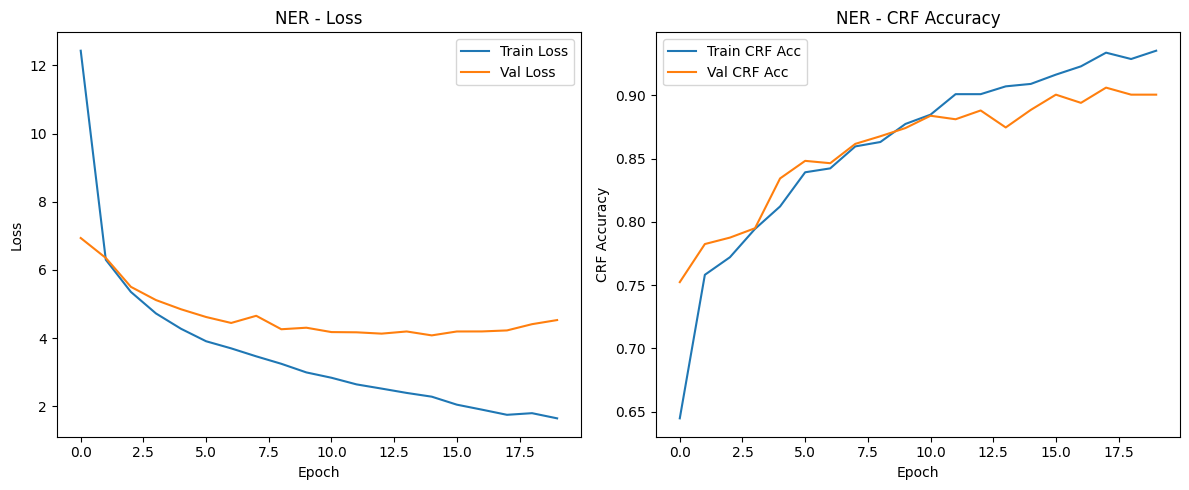

In [37]:
def plot_history(history, title):
    plt.figure(figsize=(12,5))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title + " - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy atau CRF Accuracy
    if 'accuracy' in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(title + " - Accuracy")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    elif 'crf_viterbi_accuracy' in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['crf_viterbi_accuracy'], label='Train CRF Acc')
        plt.plot(history.history['val_crf_viterbi_accuracy'], label='Val CRF Acc')
        plt.title(title + " - CRF Accuracy")
        plt.xlabel('Epoch')
        plt.ylabel('CRF Accuracy')
        plt.legend()

    plt.tight_layout()

    # Menyimpan plot sebagai gambar
    plt.savefig(f'models/{title.replace(" ", "_").lower()}_history.png')

    # Menampilkan plot
    plt.show()

# Plot riwayat pelatihan dan menyimpan gambar
plot_history(history_intent, "Klasifikasi Intent")
print("\n")
plot_history(history_ner, "NER")

In [30]:
# Menyimpan ringkasan model
def save_model_summary(model, filename):
    with open(filename, 'w') as f:
        # Membuat buffer untuk menangkap ringkasan model
        model_summary = io.StringIO()
        model.summary(print_fn=lambda x: model_summary.write(x + '\n'))
        f.write(model_summary.getvalue())

# Mengonversi history ke DataFrame dan menyimpannya sebagai CSV
def save_history(history, filename):
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(filename, index=False)

**2. Evaluasi Model Klasifikasi Intent**

Menilai performa model klasifikasi intent pada data validasi.

In [31]:
loss_intent, acc_intent = model_intent.evaluate(val_padded, val_labels_cat)
print("Akurasi Intent:", acc_intent)

3/3 [==============================] - 0s 14ms/step - loss: 0.1586 - accuracy: 0.9571
Akurasi Intent: 0.9571428298950195


**3. Evaluasi Model NER**

Menilai performa model NER pada data validasi.

In [32]:
loss_ner_crf, acc_ner_crf = model_ner_crf.evaluate(val_texts_ner, val_labels_ner)
print("Akurasi NER dengan CRF:", acc_ner_crf)

3/3 [==============================] - 0s 19ms/step - loss: 4.0798 - crf_viterbi_accuracy: 0.9008
Akurasi NER dengan CRF: 0.9008486866950989


**4. Laporan Klasifikasi Detail**

Menghasilkan laporan detail untuk Klasifikasi Intent dan NER.

In [33]:
# Laporan Klasifikasi Intent
val_pred_intent = model_intent.predict(val_padded)
val_pred_intent_labels = np.argmax(val_pred_intent, axis=1)
print("=== Laporan Klasifikasi Intent (Validasi) ===")
print(sk_classification_report(val_labels, val_pred_intent_labels, target_names=label_encoder.classes_))

# Matriks Kebingungan untuk Intent
cm = confusion_matrix(val_labels, val_pred_intent_labels)
print("Matriks Kebingungan (Intent):")
print(cm)

3/3 [==============================] - 1s 13ms/step
=== Laporan Klasifikasi Intent (Validasi) ===
                             precision    recall  f1-score   support

                   Greeting       1.00      1.00      1.00        14
 Melaporkan Hewan Terlantar       0.93      1.00      0.97        14
        Mendiagnosis Gejala       0.88      1.00      0.93        14
Rekomendasi Penanganan Awal       1.00      0.79      0.88        14
                     Thanks       1.00      1.00      1.00        14

                   accuracy                           0.96        70
                  macro avg       0.96      0.96      0.96        70
               weighted avg       0.96      0.96      0.96        70

Matriks Kebingungan (Intent):
[[14  0  0  0  0]
 [ 0 14  0  0  0]
 [ 0  0 14  0  0]
 [ 0  1  2 11  0]
 [ 0  0  0  0 14]]


In [34]:
# Laporan Klasifikasi NER
val_pred_ner_logits = model_ner_crf.predict(val_texts_ner)
viterbi_seq, _ = tfa.text.crf_decode(val_pred_ner_logits, transition_params, tf.fill([tf.shape(val_pred_ner_logits)[0]], max_seq_length))

def decode_ner_prediction(viterbi_seq, true_labels, ner_label_decoder):
    pred_tags = []
    true_tags = []
    for i in range(viterbi_seq.shape[0]):
        pred_seq = []
        true_seq = []
        for j in range(viterbi_seq.shape[1]):
            true_idx = np.argmax(true_labels[i][j])
            true_tag = ner_label_decoder[true_idx]
            pred_tag = ner_label_decoder[viterbi_seq[i][j].numpy()]
            pred_seq.append(pred_tag)
            true_seq.append(true_tag)
        pred_tags.append(pred_seq)
        true_tags.append(true_seq)
    return true_tags, pred_tags

true_tags, pred_tags = decode_ner_prediction(viterbi_seq, val_labels_ner, ner_label_decoder)
print("=== Laporan Klasifikasi NER (Validasi) ===")
print(seqeval_classification_report(true_tags, pred_tags))

3/3 [==============================] - 1s 19ms/step
=== Laporan Klasifikasi NER (Validasi) ===
              precision    recall  f1-score   support

      ANIMAL       0.93      0.96      0.95        27
   CONDITION       1.00      0.33      0.50         6
    LOCATION       0.20      0.20      0.20         5
      STATUS       0.00      0.00      0.00         4
     SYMPTOM       0.38      0.31      0.34        48

   micro avg       0.59      0.49      0.54        90
   macro avg       0.50      0.36      0.40        90
weighted avg       0.56      0.49      0.51        90



/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Menyimpan Model dan Encoder
Setelah model berhasil dilatih, kita akan menyimpan model dan encoder untuk digunakan.

In [38]:
os.makedirs('models', exist_ok=True)
os.makedirs('encoders', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Menyimpan model
model_intent.save('models/model_intent.keras')
model_ner_crf.save('models/model_ner_crf.keras')

# Menyimpan encoder dan tokenizer
with open('encoders/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('encoders/label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('encoders/ner_label_encoder.pickle', 'wb') as handle:
    pickle.dump(ner_label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('encoders/transition_params.pickle', 'wb') as handle:
    pickle.dump(transition_params.numpy(), handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Semua model, encoder, data, dan KB telah disimpan.")

Semua model, encoder, data, dan KB telah disimpan.


# Membangun Knowledge Base
Kita akan membuat basis pengetahuan berbasis retrieval dari pasangan percakapan pengguna-bot.

In [39]:
# Mengumpulkan pasangan pengguna-bot
pairs = []
for conv in conversations:
    turns = conv["turns"]
    for i in range(len(turns)-1):
        if turns[i]["speaker"] == "user" and turns[i+1]["speaker"] == "bot":
            user_utt_clean = preprocess_text(turns[i]["utterance"])
            bot_utt = turns[i+1]["utterance"]
            pairs.append((user_utt_clean, bot_utt))

# Membuat DataFrame
df_utterances = pd.DataFrame(pairs, columns=["utterances_clean","bot_response"])
df_utterances.to_pickle('data/df_utterances.pkl')

# Vectorisasi menggunakan TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df_utterances['utterances_clean'])

# Menyimpan vectorizer dan matriks TF-IDF
with open('data/vectorizer.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/tfidf_matrix.pickle', 'wb') as handle:
    pickle.dump(X_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Fungsi Respons Chatbot
Definisikan fungsi-fungsi untuk memproses input pengguna dan menghasilkan respons yang sesuai.

In [40]:
def predict_intent_nb(text):
    """
    Memprediksi intent dari input pengguna.
    """
    text_clean = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([text_clean])
    padded = pad_sequences(seq, maxlen=max_seq_length, padding='post')
    pred = model_intent.predict(padded)
    predicted_label = np.argmax(pred, axis=1)[0]
    return label_encoder.inverse_transform([predicted_label])[0]

def predict_entities_nb(text):
    """
    Memprediksi entitas dalam input pengguna.
    """
    text_clean = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([text_clean])
    padded = pad_sequences(seq, maxlen=max_seq_length, padding='post')
    logits = model_ner_crf.predict(padded)
    viterbi_seq, _ = tfa.text.crf_decode(logits, transition_params, tf.fill([tf.shape(logits)[0]], max_seq_length))
    tokens = text_clean.split()
    entities = []
    for idx, label_id in enumerate(viterbi_seq[0][:len(tokens)]):
        label = ner_label_decoder[label_id.numpy()]
        if label != 'O':
            entity_type = label.split('-')[1].lower()
            entities.append({'entity': entity_type, 'value': tokens[idx]})
    return entities

# Mapping intent ke jenis hewan
intent_animal_mapping = {
    "Melaporkan Hewan Terlantar": ["kucing", "anjing"],
    "Mendiagnosis Gejala": ["kucing", "anjing"],
    "Rekomendasi Penanganan Awal": ["kucing", "anjing"],
    "Konfirmasi Laporan": ["kucing", "anjing"],
    "Tindak Lanjut Laporan": ["kucing", "anjing"],
    "Rekomendasi Tindakan": ["kucing", "anjing"]
}

def adjust_intent_nb(intent, entities):
    """
    Menyesuaikan intent yang diprediksi berdasarkan entitas yang terdeteksi.
    """
    predicted_animals = intent_animal_mapping.get(intent, None)
    entity_animals = [ent['value'].lower() for ent in entities if ent['entity'] == 'animal']
    if entity_animals and predicted_animals:
        user_animal = entity_animals[0]
        if user_animal not in predicted_animals:
            for i_name, animals in intent_animal_mapping.items():
                if user_animal in animals:
                    intent = i_name
                    break
            else:
                intent = None
    return intent

def get_default_response():
    """
    Memberikan respons default ketika tidak ada jawaban yang sesuai ditemukan.
    """
    default_responses = [
        "Maaf, saya belum bisa menjawab pertanyaan Anda.",
        "Mohon diperjelas, saya belum mengerti konteksnya.",
        "Silakan berikan informasi lebih detail.",
        "Maaf, saya hanya diprogram untuk menjawab mengenai kucing dan anjing.",
        "Saya sarankan konsultasi langsung ke dokter hewan."
    ]
    return random.choice(default_responses)

from sklearn.metrics.pairwise import cosine_similarity

def get_best_response(user_input):
    """
    Mengambil respons terbaik dari knowledge base berdasarkan kemiripan input pengguna.
    """
    user_query_clean = preprocess_text(user_input)
    q_vec = vectorizer.transform([user_query_clean])
    sims = cosine_similarity(q_vec, X_tfidf)  # (1, n)
    best_idx = sims[0].argmax()
    best_score = sims[0][best_idx]
    if best_score < 0.5:
        return None
    else:
        return df_utterances.iloc[best_idx]['bot_response']

def get_response_nb(user_input, intent=None, entities=None):
    """
    Menghasilkan respons berdasarkan intent dan entitas.
    """
    if intent == "Mendiagnosis Gejala":
        return "Berdasarkan gejalanya, kemungkinan ada masalah kesehatan. Saya sarankan segera periksakan ke dokter hewan."
    elif intent == "Rekomendasi Penanganan Awal":
        return "Cobalah langkah penanganan awal seperti menjaga kebersihan, memberikan makanan ringan, dan konsultasikan ke dokter hewan jika berlanjut."
    else:
        best_resp = get_best_response(user_input)
        if best_resp:
            return best_resp
        else:
            return get_default_response()

def chatbot_response_nb(history, user_input):
    """
    Memproses input pengguna dan menghasilkan respons chatbot.
    """
    history.append(user_input)
    intent = predict_intent_nb(user_input)
    entities = predict_entities_nb(user_input)
    adjusted_intent = adjust_intent_nb(intent, entities)
    if adjusted_intent is None:
        response = get_response_nb(user_input, None, entities)
    else:
        response = get_response_nb(user_input, adjusted_intent, entities)
    return response

# Pengujian Chatbot
Mari kita uji chatbot dengan lima percakapan pertama dari dataset untuk melihat bagaimana performanya.

**5 data teratas dari data2.json**

```bash
[
    {
        "conversation_id": "conv_001",
        "turns": [
            {
                "speaker": "user",
                "utterance": "Saya melihat seekor kucing sakit di depan toko.",
                "entities": [
                    {
                        "entity": "animal",
                        "value": "kucing",
                        "start": 15,
                        "end": 21
                    },
                    {
                        "entity": "location",
                        "value": "depan toko",
                        "start": 29,
                        "end": 39
                    }
                ],
                "intent": "Melaporkan Hewan Terlantar"
            },
            {
                "speaker": "bot",
                "utterance": "Terima kasih atas laporannya. Apakah kucing tersebut menunjukkan gejala seperti demam atau muntah?",
                "entities": [],
                "intent": "Mendiagnosis Gejala"
            },
            {
                "speaker": "user",
                "utterance": "Kucing terlihat demam dan bersin-bersin.",
                "entities": [
                    {
                        "entity": "animal",
                        "value": "kucing",
                        "start": 0,
                        "end": 6
                    },
                    {
                        "entity": "symptom",
                        "value": "demam",
                        "start": 15,
                        "end": 20
                    },
                    {
                        "entity": "symptom",
                        "value": "bersin-bersin",
                        "start": 25,
                        "end": 39
                    }
                ],
                "intent": "Mendiagnosis Gejala"
            },
            {
                "speaker": "bot",
                "utterance": "Kucing tersebut mungkin terkena Feline Calicivirus. Sebaiknya segera hubungi komunitas terdekat melalui fitur emergency.",
                "entities": [],
                "intent": "Rekomendasi Penanganan Awal"
            }
        ]
    },
    {
        "conversation_id": "conv_002",
        "turns": [
            {
                "speaker": "user",
                "utterance": "Ada anjing terluka di jalan raya.",
                "entities": [
                    {
                        "entity": "animal",
                        "value": "anjing",
                        "start": 4,
                        "end": 10
                    },
                    {
                        "entity": "location",
                        "value": "jalan raya",
                        "start": 23,
                        "end": 33
                    }
                ],
                "intent": "Melaporkan Hewan Terlantar"
            },
            {
                "speaker": "bot",
                "utterance": "Terima kasih atas informasinya. Apakah anjing tersebut mengalami muntah atau diare?",
                "entities": [],
                "intent": "Mendiagnosis Gejala"
            },
            {
                "speaker": "user",
                "utterance": "Ya, anjing muntah dan terlihat lemas.",
                "entities": [
                    {
                        "entity": "animal",
                        "value": "anjing",
                        "start": 4,
                        "end": 10
                    },
                    {
                        "entity": "symptom",
                        "value": "muntah",
                        "start": 11,
                        "end": 17
                    },
                    {
                        "entity": "symptom",
                        "value": "lemas",
                        "start": 30,
                        "end": 35
                    }
                ],
                "intent": "Mendiagnosis Gejala"
            },
            {
                "speaker": "bot",
                "utterance": "Gejala ini dapat mengindikasikan Distemper. Gunakan fitur emergency untuk melaporkan anjing tersebut agar segera mendapatkan bantuan.",
                "entities": [],
                "intent": "Rekomendasi Penanganan Awal"
            }
        ]
    },
    {
        "conversation_id": "conv_003",
        "turns": [
            {
                "speaker": "user",
                "utterance": "Saya menemukan seekor kucing dengan luka di kaki di taman.",
                "entities": [
                    {
                        "entity": "animal",
                        "value": "kucing",
                        "start": 15,
                        "end": 21
                    },
                    {
                        "entity": "symptom",
                        "value": "luka di kaki",
                        "start": 28,
                        "end": 39
                    },
                    {
                        "entity": "location",
                        "value": "taman",
                        "start": 43,
                        "end": 48
                    }
                ],
                "intent": "Melaporkan Hewan Terlantar"
            },
            {
                "speaker": "bot",
                "utterance": "Terima kasih atas laporannya. Apakah Anda ingin melaporkan kucing ini melalui fitur emergency?",
                "entities": [],
                "intent": "Konfirmasi Laporan"
            },
            {
                "speaker": "user",
                "utterance": "Ya, tolong bantu hubungkan dengan komunitas terdekat.",
                "entities": [],
                "intent": "Melaporkan Hewan Terlantar"
            },
            {
                "speaker": "bot",
                "utterance": "Laporan telah dikirim. Komunitas terdekat akan segera menghubungi Anda.",
                "entities": [],
                "intent": "Tindak Lanjut Laporan"
            }
        ]
    },
    {
        "conversation_id": "conv_004",
        "turns": [
            {
                "speaker": "user",
                "utterance": "Ada anjing dengan kulit merah dan gatal di depan sekolah.",
                "entities": [
                    {
                        "entity": "animal",
                        "value": "anjing",
                        "start": 4,
                        "end": 10
                    },
                    {
                        "entity": "symptom",
                        "value": "kulit merah",
                        "start": 17,
                        "end": 28
                    },
                    {
                        "entity": "symptom",
                        "value": "gatal",
                        "start": 33,
                        "end": 38
                    },
                    {
                        "entity": "location",
                        "value": "depan sekolah",
                        "start": 42,
                        "end": 55
                    }
                ],
                "intent": "Melaporkan Hewan Terlantar"
            },
            {
                "speaker": "bot",
                "utterance": "Anjing tersebut mungkin mengalami masalah kulit seperti kudis. Laporkan melalui fitur emergency untuk mendapatkan bantuan.",
                "entities": [],
                "intent": "Rekomendasi Penanganan Awal"
            }
        ]
    },
    {
        "conversation_id": "conv_005",
        "turns": [
            {
                "speaker": "user",
                "utterance": "Saya menemukan kucing dengan rambut rontok di halaman rumah.",
                "entities": [
                    {
                        "entity": "animal",
                        "value": "kucing",
                        "start": 15,
                        "end": 21
                    },
                    {
                        "entity": "symptom",
                        "value": "rambut rontok",
                        "start": 28,
                        "end": 41
                    },
                    {
                        "entity": "location",
                        "value": "halaman rumah",
                        "start": 45,
                        "end": 59
                    }
                ],
                "intent": "Melaporkan Hewan Terlantar"
            },
            {
                "speaker": "bot",
                "utterance": "Gejala ini menunjukkan kemungkinan penyakit kulit. Sebaiknya gunakan fitur emergency untuk melaporkan kucing ini.",
                "entities": [],
                "intent": "Rekomendasi Penanganan Awal"
            }
        ]
    }
]
```

In [41]:
# Pengujian percakapan 1-5 di notebook:
for i, conv in enumerate(conversations[:5], start=1):
    print(f"\nPercakapan {i}: {conv['conversation_id']}")
    dialog_history = []
    for turn in conv["turns"]:
        print(f"{turn['speaker'].title()}: {turn['utterance']}")
        if turn['speaker'] == 'user':
            resp = chatbot_response_nb(dialog_history, turn['utterance'])
            print("Chatbot:", resp)


Percakapan 1: conv_001
User: Saya melihat seekor kucing sakit di depan toko.
1/1 [==============================] - 1s 1s/step
Chatbot: Terima kasih atas laporannya. Apakah kucing tersebut menunjukkan gejala seperti demam atau muntah?
Bot: Terima kasih atas laporannya. Apakah kucing tersebut menunjukkan gejala seperti demam atau muntah?
User: Kucing terlihat demam dan bersin-bersin.
1/1 [==============================] - 0s 47ms/step
Chatbot: Berdasarkan gejalanya, kemungkinan ada masalah kesehatan. Saya sarankan segera periksakan ke dokter hewan.
Bot: Kucing tersebut mungkin terkena Feline Calicivirus. Sebaiknya segera hubungi komunitas terdekat melalui fitur emergency.

Percakapan 2: conv_002
User: Ada anjing terluka di jalan raya.
1/1 [==============================] - 0s 54ms/step
Chatbot: Terima kasih atas informasinya. Apakah anjing tersebut mengalami muntah atau diare?
Bot: Terima kasih atas informasinya. Apakah anjing tersebut mengalami muntah atau diare?
User: Ya, anjing munt

In [42]:
# Menyimpan ringkasan model Intent
save_model_summary(model_intent, 'models/model_intent_summary.txt')

# Menyimpan history pelatihan model Intent
save_history(history_intent, 'models/history_intent.csv')

# Menyimpan ringkasan model NER
save_model_summary(model_ner_crf, 'models/model_ner_crf_summary.txt')

# Menyimpan history pelatihan model NER
save_history(history_ner, 'models/history_ner_crf.csv')